In [ ]:
# Import necessary libraries 

!wget -O prbs_test_18_Jun_2025_13_50_02.mat \
https://raw.githubusercontent.com/AlasMac/TCLab-Python-Resources/main/prbs_test_18_Jun_2025_13_50_02.mat

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

Matplotlib is building the font cache; this may take a moment.
/tmp/xpython_42/246179850.py:5: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.io import loadmat


In [ ]:
# ARX simulation function
def ARX_Sim_PID(A, B, k, Kp, Ki, Kd, r, mu, sigma, SIM_TIME, x0, u_thresh):
    """
    Simulates an ARX model with PID control.
    """
    t = np.arange(1, SIM_TIME + 1)  # time vector (1...SIM_TIME)

    # Reproducible Gaussian process noise
    rng = np.random.default_rng(seed=100)
    e = rng.normal(mu, sigma, size=len(t))

    na = len(A)
    nb = len(B)
    L = max(na, nb)

    # Pad A or B so lengths match
    if na > nb:
        B = np.concatenate([B, np.zeros(na - nb)])
        nb = len(B)
    elif nb > na:
        A = np.concatenate([A, np.zeros(nb - na)])
        na = len(A)

    # Preallocate
    ut = np.zeros(len(t) + L)
    y = np.ones(len(t) + L) * x0
    err = np.zeros_like(y)

    integral_err = 0
    alpha = 0.5  # derivative filter coefficient
    dt = 1.0

    # Simulation loop
    for i in range(L + k, SIM_TIME):
        # ARX system dynamics
        y[i] = -np.dot(A[1:], y[i - 1 : i - na : -1]) \
               + np.dot(B, ut[i - k : i - nb - k : -1]) \
               + e[i]

        # Error
        err[i] = r[i] - y[i]

        # Integral error
        integral_err += err[i] * dt

        # PID control law
        d_err = err[i] - err[i - 1]
        ut[i + 1] = (Kp * err[i]
                     + Ki * integral_err
                     + Kd * (alpha * d_err / dt + (1 - alpha) * d_err))

        # Saturation
        ut[i + 1] = np.clip(ut[i + 1], 0, u_thresh)

    # Trim padded part
    y = y[: -L]
    ut = ut[: -L]

    return y, ut, t

In [4]:
# --- Load MATLAB data ---
filename = 'prbs_test_18_Jun_2025_13_50_02.mat'
data = loadmat(filename)

T = data['T']
U = data['U']

y_data_test = T[0, :]
y_data_test = y_data_test - y_data_test[0]
u_data_test = U[0, :]
t_test = np.arange(len(T))

In [5]:
# --- Model parameters ---
A = [1, -3.88098254, 5.64726905, -3.6515443, 0.88525793]
B = [0.4453368, -1.71110786, 2.49838163, -1.64272524, 0.41012833]
k = 0
sigma = 1e-5

# --- Setpoint ---
N = len(u_data_test)
r = np.zeros(N, dtype=float)
r[100:] = 30

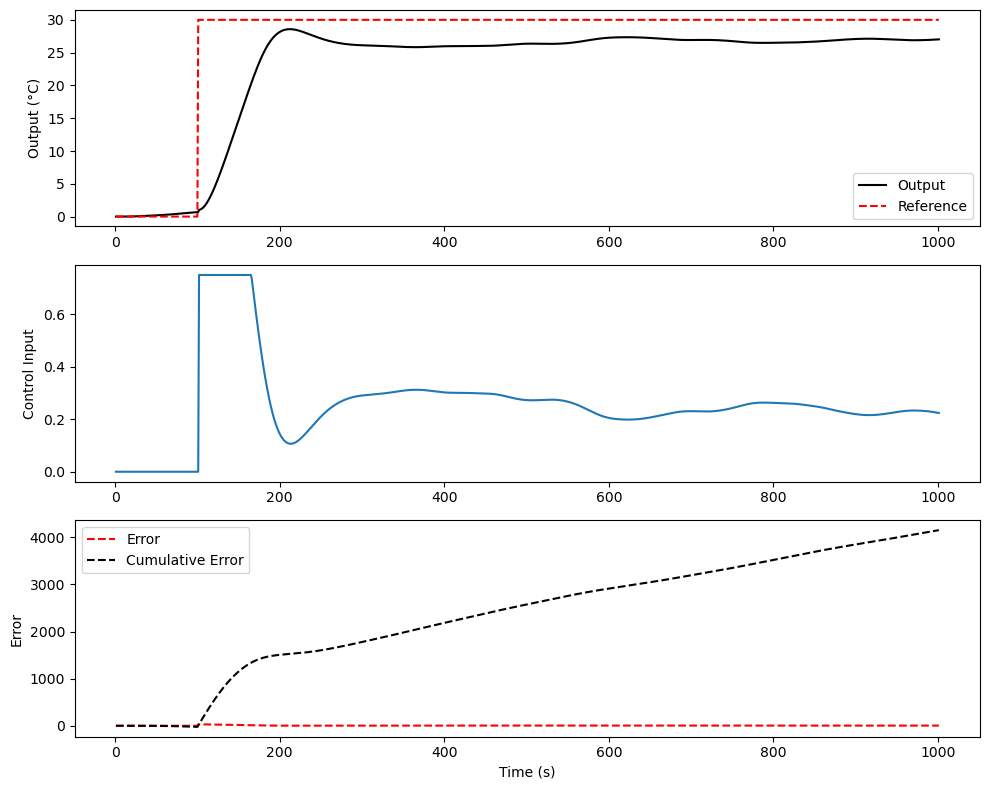

In [6]:
# ========== P Controller ==========
Kp = 0.075
Ki = 0
Kd = 0

y, u, t = ARX_Sim_PID(A, B, k, Kp, Ki, Kd, r, 0, sigma, N, y_data_test[0], 0.75)
err = r - y

plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.plot(t, y, 'k', label='Output')
plt.plot(t, r, '--r', label='Reference')
plt.ylabel('Output (°C)')
plt.legend()

plt.subplot(3,1,2)
plt.plot(t, u)
plt.ylabel('Control Input')

plt.subplot(3,1,3)
plt.plot(t, err, '--r', label='Error')
plt.plot(t, np.cumsum(err), '--k', label='Cumulative Error')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.legend()
plt.tight_layout()
plt.show()


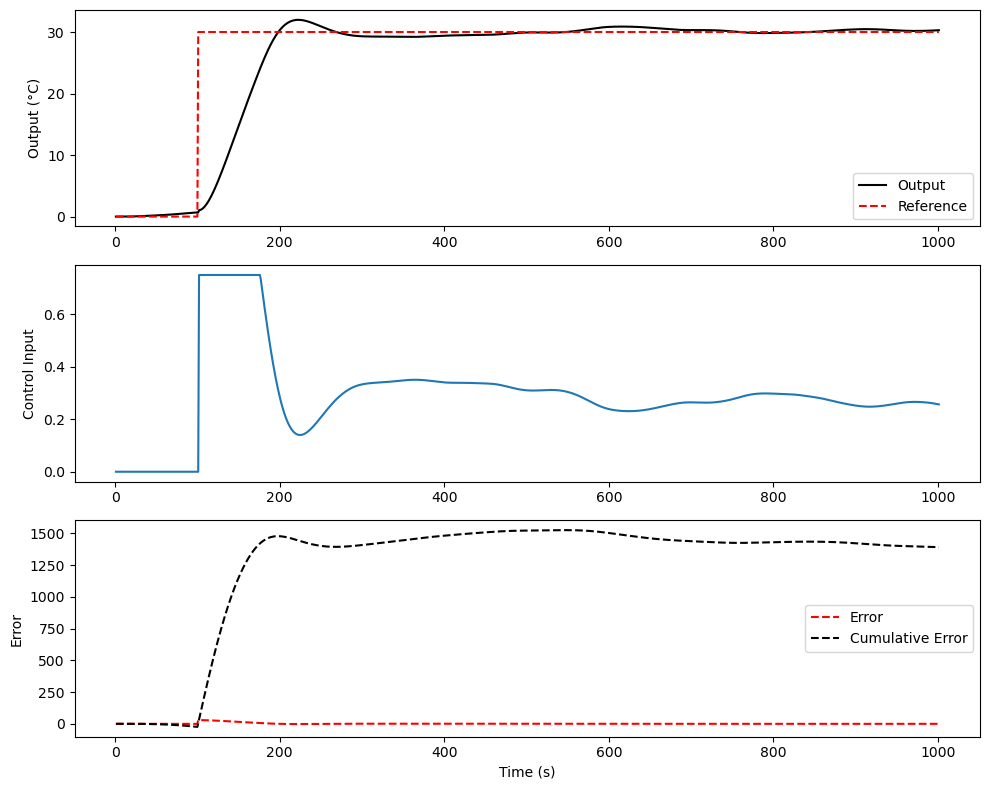

In [7]:
# ========== PI Controller ==========
Kp = 0.075 
Ki = 0.0002
Kd =  0

y, u, t = ARX_Sim_PID(A, B, k, Kp, Ki, Kd, r, 0, sigma, N, y_data_test[0], 0.75)
err = r - y

plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.plot(t, y, 'k', label='Output')
plt.plot(t, r, '--r', label='Reference')
plt.ylabel('Output (°C)')
plt.legend()

plt.subplot(3,1,2)
plt.plot(t, u)
plt.ylabel('Control Input')

plt.subplot(3,1,3)
plt.plot(t, err, '--r', label='Error')
plt.plot(t, np.cumsum(err), '--k', label='Cumulative Error')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.legend()
plt.tight_layout()
plt.show()



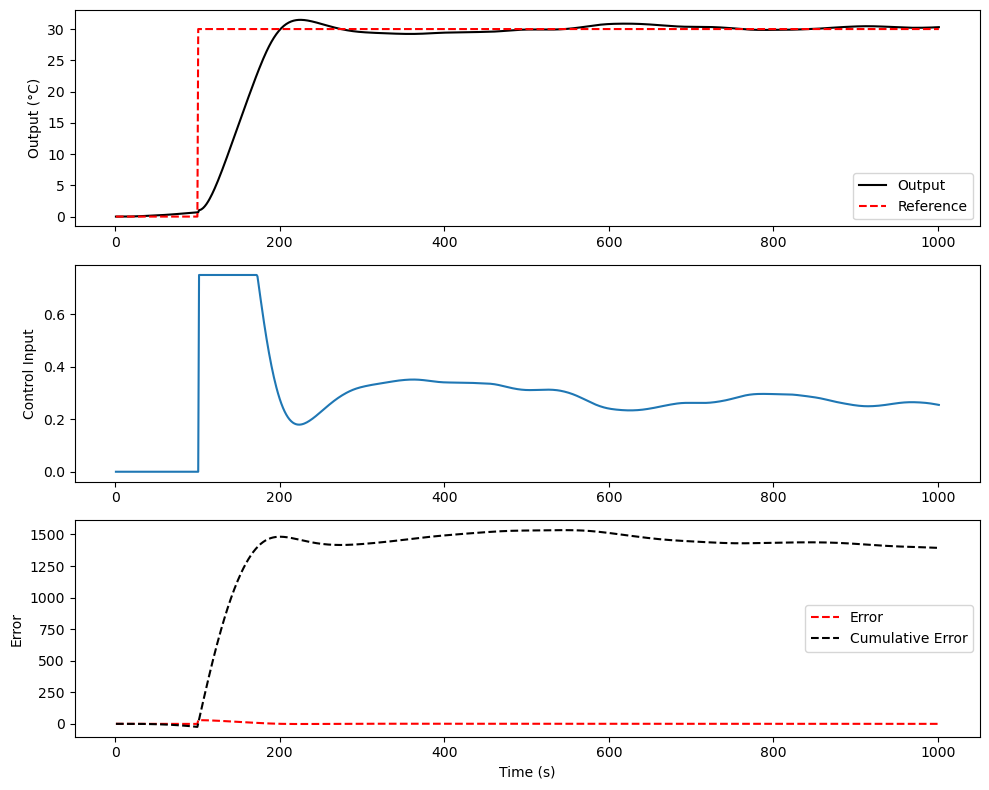

In [11]:
# ========== PID Controller ==========
Kp = 0.075
Ki = 0.0002
Kd =  0.25
y, u, t = ARX_Sim_PID(A, B, k, Kp, Ki, Kd, r, 0, sigma, N, y_data_test[0], 0.75)
err = r - y

plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.plot(t, y, 'k', label='Output')
plt.plot(t, r, '--r', label='Reference')
plt.ylabel('Output (°C)')
plt.legend()

plt.subplot(3,1,2)
plt.plot(t, u)
plt.ylabel('Control Input')

plt.subplot(3,1,3)
plt.plot(t, err, '--r', label='Error')
plt.plot(t, np.cumsum(err), '--k', label='Cumulative Error')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.legend()
plt.tight_layout()
plt.show()